<a href="https://colab.research.google.com/github/teiabessa/dio-lab-open-source/blob/main/tarefa_sistema_recomendacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
# Importando as bibliotecas necessárias

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil


import numpy as np  # Para manipulação de arrays
import matplotlib.pyplot as plt  # Para exibir gráficos de imagens
import matplotlib.image as mpimg  # Para carregar imagens

In [61]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# Caminho para a pasta pessoal no google drive

#para tirar os especos de my laptop
gdriver_mylap_folder = '/content/gdrive/Othercomputers/My\ Laptop/Categoria'

!ls -la {gdriver_mylap_folder}


Mounted at /content/gdrive
total 36
drwx------ 2 root root 4096 Feb 13 15:34  Accessories
drwx------ 2 root root 4096 Feb 13 15:49  Apparel
drwx------ 2 root root 4096 Feb 13 17:07  Camisa_xadrez
drwx------ 2 root root 4096 Feb 13 15:34  Footwear
drwx------ 2 root root 4096 Feb 13 15:34 'Free Items'
drwx------ 2 root root 4096 Feb 13 15:33  Home
drwx------ 2 root root 4096 Feb 13 15:34 'Personal Care'
drwx------ 2 root root 4096 Feb 13 15:33 'Sporting Goods'
drwx------ 2 root root 4096 Feb 13 16:55  Tenis


In [ ]:
#Rodar só a primeira vez
#já criei o kaggle.json file no diretorio mydriver/Recomendacao
#%%writefile kaggle.json
#{"username":"<your kaggle username>","key":"<your kaggle api key>"}
#login: auriceliabessa

# Roda só  a primeira vez para salvar imagens da internet

In [ ]:


"""
!pip install -q -U kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle
!mkdir ~/.kaggle
# Usando f-strings para interpolar o valor da variável no comando Linux
!cp /kaggle.json '/content/gdrive/Othercomputers/My\ Laptop/Recomendacao' ~/.kaggle/

#!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# downloading raw images from kaggle
!kaggle datasets download -d paramaggarwal/fashion-product-images-small
!unzip fashion-product-images-small.zip
"""

"\n!pip install -q -U kaggle\n!pip install --upgrade --force-reinstall --no-deps kaggle\n!mkdir ~/.kaggle\n# Usando f-strings para interpolar o valor da variável no comando Linux\n!cp /kaggle.json '/content/gdrive/Othercomputers/My\\ Laptop/Recomendacao' ~/.kaggle/\n\n#!cp kaggle.json ~/.kaggle/\n!chmod 600 ~/.kaggle/kaggle.json\n\n# downloading raw images from kaggle\n!kaggle datasets download -d paramaggarwal/fashion-product-images-small\n!unzip fashion-product-images-small.zip\n"

# Função que organiza diretorios em categorias
Roda somente a primeira vez

In [ ]:
import pandas as pd
from shutil import move
import os
from tqdm import tqdm

os.mkdir('/content/Fashion_data')
os.chdir('/content/Fashion_data')

df = pd.read_csv('/content/styles.csv', usecols=['id','masterCategory']).reset_index()
df['id'] = df['id'].astype('str')

all_images = os.listdir('/content/images/')
co = 0
os.mkdir('/content/Fashion_data/categories')
for image in tqdm(all_images):
    category = df[df['id'] == image.split('.')[0]]['masterCategory']
    category = str(list(category)[0])
    if not os.path.exists(os.path.join('/content/Fashion_data/categories', category)):
        os.mkdir(os.path.join('/content/Fashion_data/categories', category))
    path_from = os.path.join('/content/images', image)
    path_to = os.path.join('/content/Fashion_data/categories', category, image)
    move(path_from, path_to)
    co += 1
print('Moved {} images.'.format(co))

# Comando para copiar os arquivos para a pasta google do meu computador
# Adiciona o argumento dirs_exist_ok=True para permitir a cópia
# mesmo se o diretório de destino já existir.

shutil.copytree('/content/Fashion_data/categories', gdriver_mylap_folder, dirs_exist_ok=True)

100%|██████████| 44441/44441 [03:16<00:00, 225.84it/s]

Moved 44441 images.


In [70]:
IMG_SIZE = (224, 224)  # Reduzido para melhor performance
BATCH_SIZE = 32        # Aumentado para acelerar treino
EPOCHS = 20
CLASSES = ['Tenis', 'Camisa_xadrez', 'Relogio', 'Bolsa_feminina']

gdriver_recomendacao = "/content/gdrive/Othercomputers/My Laptop/Recomendacao"

DATA_PATH = "/content/gdrive/Othercomputers/My Laptop/Categoria"


In [71]:
# Carregar o modelo pré-treinado
base_model = ResNet50(weights='imagenet', include_top=False)

# Congelar as camadas iniciais
for layer in base_model.layers:
    layer.trainable = False

# Adicionar novas camadas para ajuste fino
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(CLASSES), activation='softmax')(x)

# Criar o modelo final
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar o modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

3- Preparar os Dados

In [72]:
# Data augmentation

# Data augmentation com divisão de validação
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Gerador de dados de treinamento
train_generator = datagen.flow_from_directory(
    DATA_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    classes=CLASSES  # Forçar ordem das classes
)


val_generator = train_datagen.flow_from_directory(
    DATA_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    classes=CLASSES
)

Found 201 images belonging to 4 classes.
Found 0 images belonging to 4 classes.


In [73]:
# ======================================
# VERIFICAR CLASSES
# ======================================
print("\nClasses detectadas após limpeza:")
print(train_generator.class_indices)


Classes detectadas após limpeza:
{'Tenis': 0, 'Camisa_xadrez': 1, 'Relogio': 2, 'Bolsa_feminina': 3}


In [76]:
model.fit(train_generator, epochs=EPOCHS, steps_per_epoch=train_generator.samples // 32)

feature_extractor = Model(inputs=model.input, outputs=model.layers[-2].output)

"""def extract_features(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    features = feature_extractor.predict(img_array)
    return features
"""
#function to ensure it returns a 2D array
def extract_features(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    features = feature_extractor.predict(img_array)
    # Reshape to 2D if necessary
    features = features.reshape(features.shape[0], -1)  # Reshape to (number_of_samples, number_of_features)
    return features

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 48s 7s/step - accuracy: 0.5716 - loss: 0.9315
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.5000 - loss: 0.9759
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 61s 6s/step - accuracy: 0.6934 - loss: 0.8823
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.5000 - loss: 0.9583
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 80s 6s/step - accuracy: 0.6371 - loss: 0.8780
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7778 - loss: 0.7467
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 35s 6s/step - accuracy: 0.6617 - loss: 0.8168
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.4688 - loss: 1.1014
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step - accuracy: 0.6353 - loss: 0.9112
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6250 - loss: 0.7495
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 35s 6s/step - accuracy: 0.6930 - loss: 0.8256
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8438 - loss: 0.7765
Epoch 13/20
6

**Faz a similaridade entre os arquivos do diretorio recomendacao e suas respectivas classes**


# Faz a comparação de similaridade

 query_image_path= /content/gdrive/Othercomputers/My Laptop/Recomendacao/Tenis.jpg
category_image_paths aqui ['/content/gdrive/Othercomputers/My Laptop/Categoria/Tenis/13166.jpg', '/content/gdrive/Othercomputers/My Laptop/Categoria/Tenis/13179.jpg', '/content/gdrive/Othercomputers/My Laptop/Categoria/Tenis/13164.jpg', '/content/gdrive/Othercomputers/My Laptop/Categoria/Tenis/13167.jpg', '/content/gdrive/Othercomputers/My Laptop/Categoria/Tenis/13165.jpg', '/content/gdrive/Othercomputers/My Laptop/Categoria/Tenis/1549.jpg', '/content/gdrive/Othercomputers/My Laptop/Categoria/Tenis/1548.jpg', '/content/gdrive/Othercomputers/My Laptop/Categoria/Tenis/1642.jpg', '/content/gdrive/Othercomputers/My Laptop/Categoria/Tenis/1789.jpg', '/content/gdrive/Othercomputers/My Laptop/Categoria/Tenis/1788.jpg', '/content/gdrive/Othercomputers/My Laptop/Categoria/Tenis/1787.jpg', '/content/gdrive/Othercomputers/My Laptop/Categoria/Tenis/1827.jpg', '/content/gdrive/Othercomputers/My Laptop/Categoria/Tenis

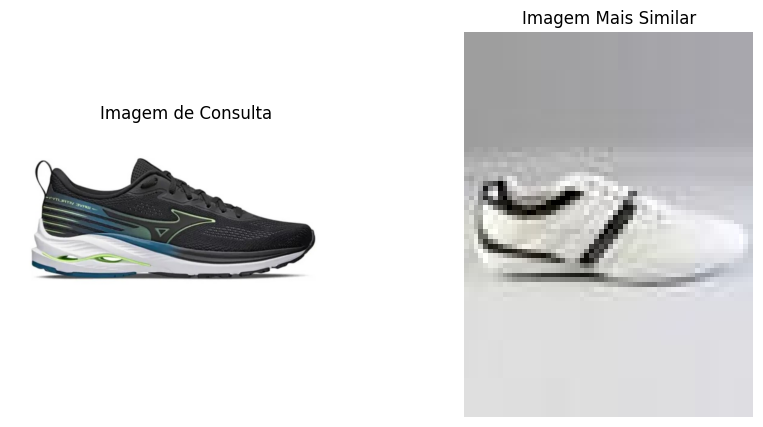

 query_image_path= /content/gdrive/Othercomputers/My Laptop/Recomendacao/Camisa_xadrez.jpg
category_image_paths aqui ['/content/gdrive/Othercomputers/My Laptop/Categoria/Camisa_xadrez/2093.jpg', '/content/gdrive/Othercomputers/My Laptop/Categoria/Camisa_xadrez/2094.jpg', '/content/gdrive/Othercomputers/My Laptop/Categoria/Camisa_xadrez/2104.jpg', '/content/gdrive/Othercomputers/My Laptop/Categoria/Camisa_xadrez/2101.jpg', '/content/gdrive/Othercomputers/My Laptop/Categoria/Camisa_xadrez/2098.jpg', '/content/gdrive/Othercomputers/My Laptop/Categoria/Camisa_xadrez/2099.jpg', '/content/gdrive/Othercomputers/My Laptop/Categoria/Camisa_xadrez/2128.jpg', '/content/gdrive/Othercomputers/My Laptop/Categoria/Camisa_xadrez/2096.jpg', '/content/gdrive/Othercomputers/My Laptop/Categoria/Camisa_xadrez/2131.jpg', '/content/gdrive/Othercomputers/My Laptop/Categoria/Camisa_xadrez/2100.jpg', '/content/gdrive/Othercomputers/My Laptop/Categoria/Camisa_xadrez/2102.jpg', '/content/gdrive/Othercomputers/My 

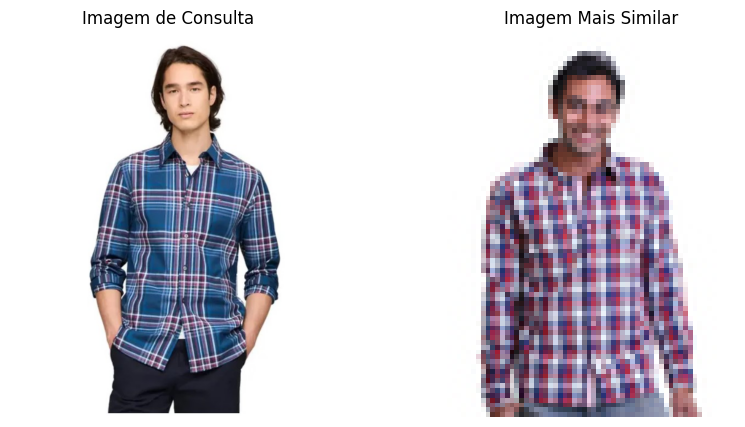

 query_image_path= /content/gdrive/Othercomputers/My Laptop/Recomendacao/Relogio.jpg
category_image_paths aqui ['/content/gdrive/Othercomputers/My Laptop/Categoria/Relogio/8099.jpg', '/content/gdrive/Othercomputers/My Laptop/Categoria/Relogio/8116.jpg', '/content/gdrive/Othercomputers/My Laptop/Categoria/Relogio/8095.jpg', '/content/gdrive/Othercomputers/My Laptop/Categoria/Relogio/8108.jpg', '/content/gdrive/Othercomputers/My Laptop/Categoria/Relogio/8096.jpg', '/content/gdrive/Othercomputers/My Laptop/Categoria/Relogio/8106.jpg', '/content/gdrive/Othercomputers/My Laptop/Categoria/Relogio/8101.jpg', '/content/gdrive/Othercomputers/My Laptop/Categoria/Relogio/8104.jpg', '/content/gdrive/Othercomputers/My Laptop/Categoria/Relogio/8112.jpg', '/content/gdrive/Othercomputers/My Laptop/Categoria/Relogio/8102.jpg', '/content/gdrive/Othercomputers/My Laptop/Categoria/Relogio/8124.jpg', '/content/gdrive/Othercomputers/My Laptop/Categoria/Relogio/8110.jpg', '/content/gdrive/Othercomputers/My L

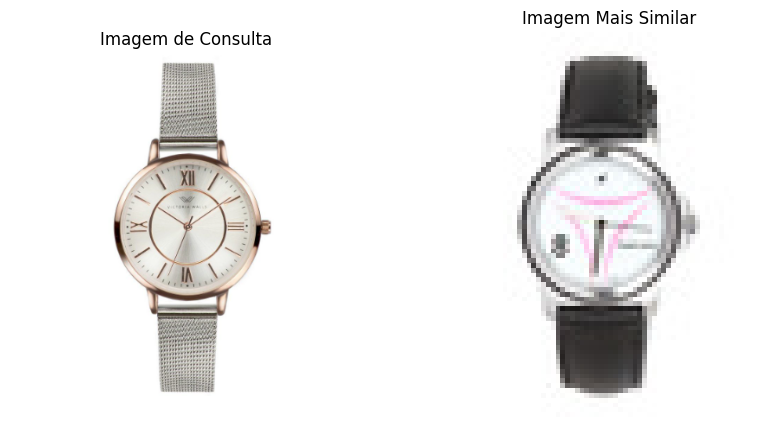

 query_image_path= /content/gdrive/Othercomputers/My Laptop/Recomendacao/Bolsa_feminina.jpg
category_image_paths aqui ['/content/gdrive/Othercomputers/My Laptop/Categoria/Bolsa_feminina/4615.jpg', '/content/gdrive/Othercomputers/My Laptop/Categoria/Bolsa_feminina/4587.jpg', '/content/gdrive/Othercomputers/My Laptop/Categoria/Bolsa_feminina/3391.jpg', '/content/gdrive/Othercomputers/My Laptop/Categoria/Bolsa_feminina/3384.jpg', '/content/gdrive/Othercomputers/My Laptop/Categoria/Bolsa_feminina/3385.jpg', '/content/gdrive/Othercomputers/My Laptop/Categoria/Bolsa_feminina/3386.jpg', '/content/gdrive/Othercomputers/My Laptop/Categoria/Bolsa_feminina/3381.jpg', '/content/gdrive/Othercomputers/My Laptop/Categoria/Bolsa_feminina/3390.jpg', '/content/gdrive/Othercomputers/My Laptop/Categoria/Bolsa_feminina/3389.jpg', '/content/gdrive/Othercomputers/My Laptop/Categoria/Bolsa_feminina/3387.jpg', '/content/gdrive/Othercomputers/My Laptop/Categoria/Bolsa_feminina/3382.jpg', '/content/gdrive/Otherc

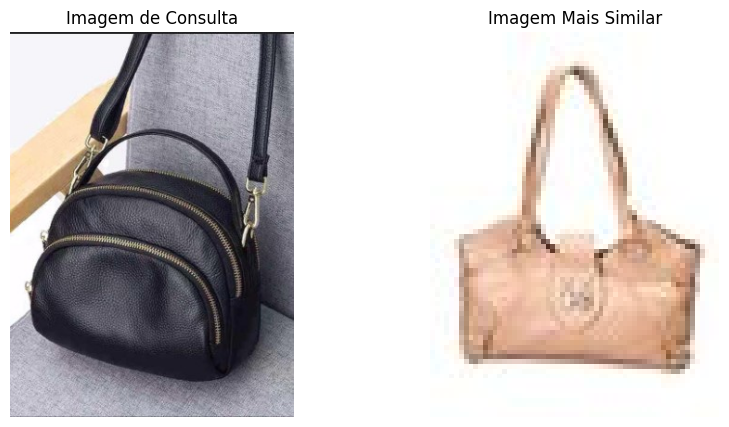

In [83]:
CLASSES = ['Tenis', 'Camisa_xadrez', 'Relogio', 'Bolsa_feminina']
gdriver_recomendacao = "/content/gdrive/Othercomputers/My Laptop/Recomendacao"

DATA_PATH = "/content/gdrive/Othercomputers/My Laptop/Categoria"
# Função para obter os caminhos das imagens de uma categoria específica
# Função para obter os caminhos das imagens de uma categoria específica
def get_image_paths_from_category(category):
    category_folder = os.path.join(DATA_PATH, category)  # Caminho para a pasta da categoria

    if not os.path.exists(category_folder):  # Verifica se o diretório existe
        print(f"Erro: O diretório {category_folder} não existe.")
        return []

    # Lista de arquivos .jpg na categoria
    image_paths = [os.path.join(category_folder, filename) for filename in os.listdir(category_folder) if filename.endswith('.jpg')]

    return image_paths

# Função para encontrar a imagem mais similar a partir da consulta
def get_most_similar_image(query_image_path, image_paths):
    # Extrai as características da imagem de consulta
    query_features = extract_features(query_image_path)

    # Extrai as características de todas as imagens
    image_features = [extract_features(img_path) for img_path in image_paths]

    # Empilha as características em uma matriz 2D
    image_features = np.vstack(image_features)

    # Calcula a similaridade entre a imagem de consulta e as imagens
    similarities = cosine_similarity(query_features, image_features)

    # Encontra o índice da imagem mais similar (maior similaridade)
    similar_image_index = np.argmax(similarities)

    return image_paths[similar_image_index]  # Retorna o caminho da imagem mais similar

# Laço para rodar a consulta para todas as classes (Tenis, Camisa_Xadrez, Relogio, Bolsa_feminina)
for category in CLASSES:
    query_image_path = os.path.join(gdriver_recomendacao, category + ".jpg")  # Caminho da imagem de consulta para a classe
    print(" query_image_path=", query_image_path)

    # Obter os caminhos das imagens da categoria atual
    category_image_paths = get_image_paths_from_category(category)
    print("category_image_paths aqui", category_image_paths)

    # Chama a função para encontrar a imagem mais similar
    similar_image = get_most_similar_image(query_image_path, category_image_paths)

    # Exibe o caminho da imagem mais similar
    print("Imagem mais similar da classe:", category, " é:", similar_image)

    # Carrega as imagens usando matplotlib
    query_img = mpimg.imread(query_image_path)
    similar_img = mpimg.imread(similar_image)

    # Cria um gráfico para exibir as imagens lado a lado
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Exibe a imagem de consulta
    axes[0].imshow(query_img)
    axes[0].set_title("Imagem de Consulta")
    axes[0].axis('off')  # Remove os eixos

    # Exibe a imagem mais similar
    axes[1].imshow(similar_img)
    axes[1].set_title("Imagem Mais Similar")
    axes[1].axis('off')  # Remove os eixos

    # Mostra o gráfico
    plt.show()




